--> Using RandomForestRegressor to predict the future values for Electricity Production

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('Electric_Production.csv')

data.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [3]:
data.rename(columns={'IPG2211A2N': 'Electric_Production'}, inplace=True)

--> Training and evaluating the model

In [4]:
n_lags = 20

# Function to create lag features
def create_features(data, target_col, n_lags=12):
    df = data.copy()
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

In [5]:
supervised_data = create_features(data, target_col = 'Electric_Production', n_lags=n_lags)

X = supervised_data.drop(columns=['Electric_Production'])
Y = supervised_data['Electric_Production']

In [6]:
if 'DATE' in X.columns:
    X = X.drop(columns=['DATE'])

In [7]:
X

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
20,64.4816,65.7655,59.9005,55.8137,57.0329,62.2221,67.9869,73.3057,68.7145,58.0005,56.3154,60.5846,63.2485,62.6202,58.0904,55.3151,57.4714,62.4502,70.6720,72.5052
21,61.0005,64.4816,65.7655,59.9005,55.8137,57.0329,62.2221,67.9869,73.3057,68.7145,58.0005,56.3154,60.5846,63.2485,62.6202,58.0904,55.3151,57.4714,62.4502,70.6720
22,57.5322,61.0005,64.4816,65.7655,59.9005,55.8137,57.0329,62.2221,67.9869,73.3057,68.7145,58.0005,56.3154,60.5846,63.2485,62.6202,58.0904,55.3151,57.4714,62.4502
23,59.3417,57.5322,61.0005,64.4816,65.7655,59.9005,55.8137,57.0329,62.2221,67.9869,73.3057,68.7145,58.0005,56.3154,60.5846,63.2485,62.6202,58.0904,55.3151,57.4714
24,68.1354,59.3417,57.5322,61.0005,64.4816,65.7655,59.9005,55.8137,57.0329,62.2221,67.9869,73.3057,68.7145,58.0005,56.3154,60.5846,63.2485,62.6202,58.0904,55.3151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,108.9312,112.1538,102.1532,92.0805,88.3530,101.0396,99.4901,114.8505,112.7694,92.8900,91.4867,102.7637,115.5159,114.5397,104.0375,90.7369,89.3254,95.3548,106.6688,117.0837
393,98.6154,108.9312,112.1538,102.1532,92.0805,88.3530,101.0396,99.4901,114.8505,112.7694,92.8900,91.4867,102.7637,115.5159,114.5397,104.0375,90.7369,89.3254,95.3548,106.6688
394,93.6137,98.6154,108.9312,112.1538,102.1532,92.0805,88.3530,101.0396,99.4901,114.8505,112.7694,92.8900,91.4867,102.7637,115.5159,114.5397,104.0375,90.7369,89.3254,95.3548
395,97.3359,93.6137,98.6154,108.9312,112.1538,102.1532,92.0805,88.3530,101.0396,99.4901,114.8505,112.7694,92.8900,91.4867,102.7637,115.5159,114.5397,104.0375,90.7369,89.3254


In [8]:
Y

20      61.0005
21      57.5322
22      59.3417
23      68.1354
24      73.8152
         ...   
392     98.6154
393     93.6137
394     97.3359
395    114.7212
396    129.4048
Name: Electric_Production, Length: 377, dtype: float64

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [10]:
import xgboost
import sklearn

print(f"xgboost version: {xgboost.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")


xgboost version: 2.1.3
scikit-learn version: 1.6.0


In [11]:
model = RandomForestRegressor()

In [12]:
model.fit(X_train, Y_train)

RandomForestRegressor()

In [13]:
y_pred = model.predict(X_test)

In [14]:
y_pred

array([ 90.136041,  91.428574, 112.38682 , 117.333939, 108.734076,
        98.765919,  89.773842,  90.098613, 104.319709, 114.309877,
       110.453286,  98.023911,  89.843793,  92.619842, 107.276068,
       112.775275, 107.362142,  95.194503,  90.281303,  91.749807,
       105.04549 , 112.372861, 107.448274,  99.310486,  91.081834,
        97.616549, 108.779366, 116.456338, 107.882174, 101.34111 ,
        90.604642,  90.461865, 102.756015, 109.994202, 109.2278  ,
        98.806771,  91.562315, 101.235682, 111.958452, 116.933382,
       109.647938, 103.234872,  90.715977,  91.692353, 103.468635,
       110.053023, 108.971301,  99.302257,  91.841819, 101.862169,
       110.240757, 116.993052, 114.042606, 103.004424,  89.90128 ,
        90.854641, 103.617099, 111.317312, 108.675386,  99.638546,
        91.359724,  91.813014, 106.71923 , 117.028341, 108.895953,
        99.416638,  90.893103,  89.616586, 104.817219, 114.540265,
       112.924015, 100.737619,  91.358214,  91.309813, 111.407

In [15]:
mse = mean_squared_error(Y_test, y_pred)
rmse = np.sqrt(mse)
print(mse, rmse)

15.873112990322992 3.9841075525546485


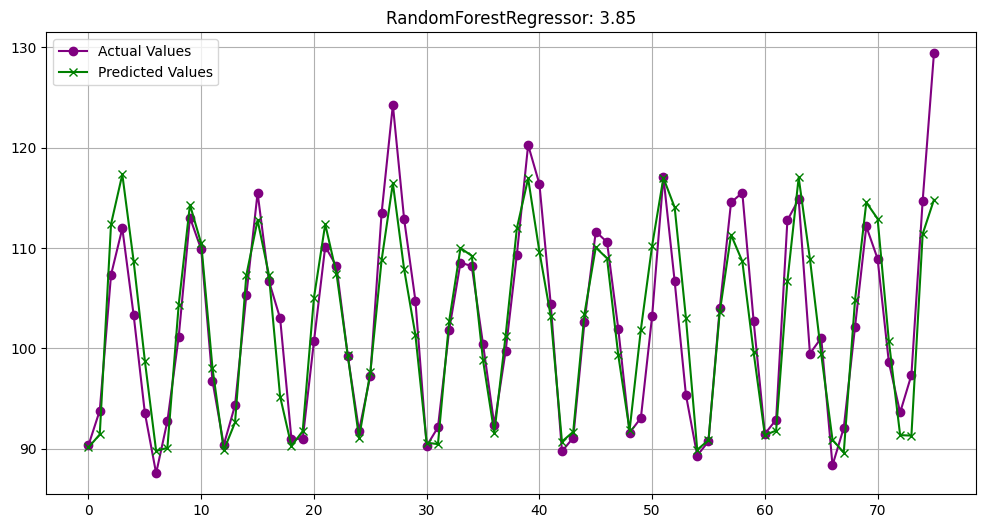

In [16]:
plt.figure(figsize=(12, 6))
plt.title('RandomForestRegressor: 3.85')
plt.plot(Y_test.values, label='Actual Values', color='purple', marker='o')
plt.plot(y_pred, label='Predicted Values', color='green', marker='x')
plt.legend()
plt.grid()
plt.show()

--> Using the model for making actual future predictions

In [17]:
start_date = pd.to_datetime('2018-02-01')
end_date = pd.to_datetime('2019-01-01')
future_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

future_dates

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [18]:
last_values = data['Electric_Production'][-n_lags:].values[::-1]

last_values

array([129.4048, 114.7212,  97.3359,  93.6137,  98.6154, 108.9312,
       112.1538, 102.1532,  92.0805,  88.353 , 101.0396,  99.4901,
       114.8505, 112.7694,  92.89  ,  91.4867, 102.7637, 115.5159,
       114.5397, 104.0375])

In [19]:
future_preds = []

for date in future_dates:
    
    future_features = {f'lag_{i+1}': last_values[i] for i in range(n_lags)}
    feature_df = pd.DataFrame([future_features])

    prediction = model.predict(feature_df)[0]
    future_preds.append(prediction)

    last_values = np.roll(last_values, shift=1)

future_preds

[105.96764500000006,
 100.68117899999999,
 90.57048699999994,
 91.051565,
 105.42509599999998,
 110.25375600000002,
 108.37727800000005,
 101.15736100000004,
 95.26609200000001,
 101.66603800000001,
 112.03373000000003,
 114.75028900000001]

In [20]:
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predictions': future_preds
})

future_df

,Date,Predictions
0,2018-02-01,105.967645
1,2018-03-01,100.681179
2,2018-04-01,90.570487
3,2018-05-01,91.051565
4,2018-06-01,105.425096
5,2018-07-01,110.253756
6,2018-08-01,108.377278
7,2018-09-01,101.157361
8,2018-10-01,95.266092
9,2018-11-01,101.666038


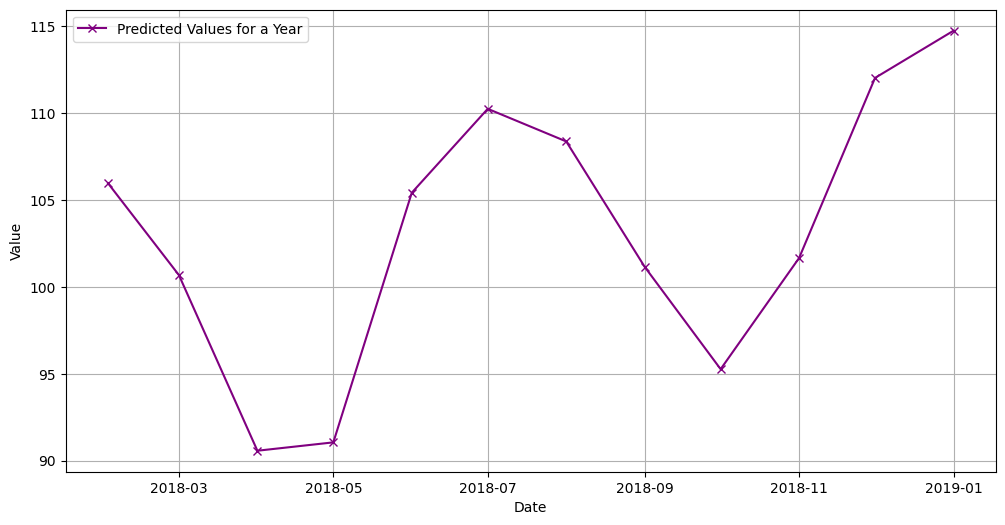

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(future_df['Date'], future_df['Predictions'], label='Predicted Values for a Year', marker='x', color='purple')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

In [22]:
data['DATE'] = pd.to_datetime(data['DATE'])

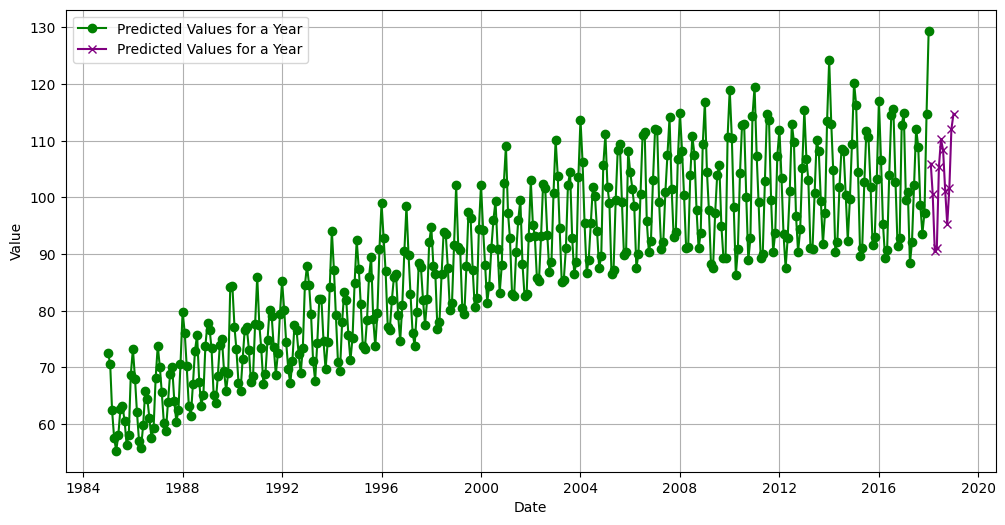

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(data['DATE'], data['Electric_Production'], label='Predicted Values for a Year', marker='o', color='green')
plt.plot(future_df['Date'], future_df['Predictions'], label='Predicted Values for a Year', marker='x', color='purple')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()